TODO: 
* test data as whole, not couple of chunks
* visualisation for diagnosing
* saving output of training to file


Architectures:
* cnn + lstm: https://stats.stackexchange.com/questions/252095/sequence-classification-via-neural-networks
* user models from keras applications: https://keras.io/applications/

In [14]:
from IPython.core.debugger import set_trace

import numpy as np

#display all values from array
np.set_printoptions(threshold=np.nan)
#display not in scientific format
np.set_printoptions(suppress=True)

import math

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dropout, LSTM, GRU, BatchNormalization, Activation
from keras.optimizers import RMSprop, SGD, Adam
from keras import callbacks
from keras.constraints import maxnorm

from sklearn.model_selection import train_test_split, StratifiedKFold

CHUNK_SIZE_IN_SECONDS = 2

In [16]:
from time import time
import datetime

def create_current_time():
    timestamp = time()
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')


def end_time(start_time):
    end_time = time() - start_time
    return round(end_time, 2)

In [17]:
import inspect

def get_function_name():
    return inspect.stack()[1][3]

In [18]:
from data_reader import get_data

def load_data_kfold(folds_number, test_size=0.05):
    x, y = get_data(CHUNK_SIZE_IN_SECONDS)
    
    x_train, x_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=test_size)
    
    folds = list(StratifiedKFold(n_splits=folds_number, 
                                 shuffle=True, 
                                 random_state=1).split(x_train, y_train))
    
    return folds, x_train, y_train, x_test, y_test

def load_data_train_test(test_size=0.05):
    x, y = get_data(CHUNK_SIZE_IN_SECONDS)
    
    x_train, x_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=test_size)
    
    return x_train, y_train, x_test, y_test

In [19]:
def step_decay(epoch):    
    initial_lrate=0.1
    drop=0.6
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate


def callbacks_list(description): 
    return [
    callbacks.EarlyStopping(
        monitor='val_acc', 
        patience=30
    ),
    callbacks.LearningRateScheduler(step_decay),
        
    callbacks.ModelCheckpoint(
        filepath='tmp/best_model.h5', 
        monitor='val_acc',
        save_best_only=True
    ),
    callbacks.TensorBoard(
        log_dir='tmp/logs/{}. {}'.format(description, create_current_time()),
        histogram_freq=0, #it has to be 0, otherwise throws error during training
        write_graph=True,
        write_images=True
    )
]

In [20]:
def run_pipeline(create_model, folds, x, y, epochs):
    score = []
    best_model_score = []
    
    for fold_number, (train_idx, val_idx) in enumerate(folds):
        print('\nFold: ', fold_number)
        x_train_cv = x[train_idx]
        y_train_cv = y[train_idx]
        x_valid_cv = x[val_idx]
        y_valid_cv = y[val_idx]
                
        input_shape = x.shape[1:]

        model, model_description = create_model(input_shape)

        callbacks = callbacks_list("{}. Fold: {}.".format(model_description, 
                                                          fold_number))

        history = model.fit(x_train_cv,
                            y_train_cv,
                            epochs=epochs,
                            batch_size=16,
                            callbacks=callbacks,
                            validation_data=(x_valid_cv, y_valid_cv),
                            verbose=0)

        score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))

        model.load_weights("tmp/best_model.h5")
        best_model_score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))
        
#         print("--Last epoch validation accuracy: %.2f%%" % (score[fold_number][1]*100))
        print("--Best model validation accuracy: %.2f%%" % (best_model_score[fold_number][1]*100))
        
    return score, best_model_score

In [21]:
folds, x_train, y_train, x_test, y_test = load_data_kfold(folds_number=10)

# add dimmension for conv2d
x_train_3d = x_train
x_train_3d = np.expand_dims(x_train_3d, axis=3)

x_test_3d = x_test
x_test_3d = np.expand_dims(x_test_3d, axis=3)

# x_train, y_train, x_test, y_test = load_data_train_test()

In [22]:
#78%
# lr decay disabled
def conv_1D_smaller_32_16_with_adam(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
#     lr=3e-5
    model.compile(
        optimizer=Adam(),                  
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description

# 80%
def conv1D_with_batch(input_shape):
    description = get_function_name()
    
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=6, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=64, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=32, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(64,activation = 'relu',name='fc0'))
    model.add(Dropout(0.25))
    model.add(Dense(32,activation = 'relu',name='fc1'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
                optimizer=SGD(lr=0.01, momentum=0.5, decay=0.0, nesterov=False), 

                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description


def conv_2D_test(input_shape):
    description = get_function_name()
    
    model = Sequential()
    
    model.add(Conv2D(64,(3,3),strides = (1,1),name='layer_conv1',padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2),name='maxPool1'))
    
    model.add(Conv2D(64,(3,3),strides = (1,1),name='layer_conv2',padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2),name='maxPool2'))
    
    model.add(Conv2D(32,(3,3),strides = (1,1),name='conv3',padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2),name='maxPool3'))
    
#     model.add(LSTM(100))
    
    model.add(Flatten())
    model.add(Dense(64,activation = 'relu',name='fc0'))
    model.add(Dropout(0.25))
    model.add(Dense(32,activation = 'relu',name='fc1'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(              
        optimizer=SGD(lr=0.01, momentum=0.5, decay=0.0, nesterov=False), 
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description

#  < 80% long training
def conv1D_lstm(input_shape):
    description = get_function_name()
    
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=6, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=64, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=32, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(100))
    
#     model.add(Flatten())
    model.add(Dense(64,activation = 'relu',name='fc0'))
    model.add(Dropout(0.25))
    model.add(Dense(32,activation = 'relu',name='fc1'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
                optimizer=SGD(lr=0.01, momentum=0.5, decay=0.0, nesterov=False), 

                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description

In [23]:
# BEST ONE
# 80%
# lr decay callback enabled
def conv_2D(input_shape):
    description = get_function_name()
    
    model = Sequential()
    
    model.add(Conv2D(64,(3,3),strides = (1,1),name='layer_conv1',padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2),name='maxPool1'))
    
    model.add(Conv2D(64,(3,3),strides = (1,1),name='layer_conv2',padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2),name='maxPool2'))
    
    model.add(Conv2D(32,(3,3),strides = (1,1),name='conv3',padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2,2),name='maxPool3'))
    
    model.add(Flatten())
    model.add(Dense(64,activation = 'relu',name='fc0'))
    model.add(Dropout(0.25))
    model.add(Dense(32,activation = 'relu',name='fc1'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(              
        optimizer=SGD(lr=0.01, momentum=0.5, decay=0.0, nesterov=False), 
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description

In [24]:
def print_model(model, x):
    model, description = model(x.shape[1:])
    print("Model:", description)
    print(model.summary())

In [25]:
model = conv_2D
print_model(model, x_train_3d)

number_of_iterations = 3

avg_accuracies = []
std_accuracies = []

for iteration in range(0, number_of_iterations):
    iteration_number = iteration + 1 
    print("Iteration", iteration_number)
    start_time = time()
    
    score, best_model_score = run_pipeline(create_model=model,
                                           folds=folds,
#                                            x=x_train,
                                           x=x_train_3d,
                                           y=y_train,
                                           epochs=100)

    print("\n")
    accuracy = [row[1] for row in best_model_score]

    avg_accuracy = np.mean(accuracy)
    print("Best models average validation accuracy: {}".format(round(avg_accuracy, 6)))

    std_accuracy = np.std(accuracy)
    print("Best models standard deviation of accuracy: {}".format(round(std_accuracy, 6)))
    
    avg_accuracies.append(avg_accuracy)
    std_accuracies.append(std_accuracy)
    
    print("Iteration", iteration_number, "time:", end_time(start_time), "seconds")
    print("\n")
    
    
grand_mean_avg = np.mean(avg_accuracies)
grand_mean_std = np.mean(std_accuracies)
print("~~~Grand mean of average accuracy: {}".format(round(grand_mean_avg, 6)))
print("~~~Grand mean of standard deviation accuracy: {}".format(round(grand_mean_std, 6)))

# todo: run on test data

Model: conv_2D
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 200, 16, 64)       640       
_________________________________________________________________
batch_normalization_88 (Batc (None, 200, 16, 64)       256       
_________________________________________________________________
activation_88 (Activation)   (None, 200, 16, 64)       0         
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 100, 8, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 100, 8, 64)        36928     
_________________________________________________________________
batch_normalization_89 (Batc (None, 100, 8, 64)        256       
_________________________________________________________________
activation_89 (Activation)   (None, 100, 8, 64)        0     

In [26]:
#bad models

# bad
def cnn_lstm(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(100))
    
#     model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=RMSprop(lr=3e-5),
                      loss='binary_crossentropy',
                      metrics=['acc'])
    
    return model, description


def dense(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(1000, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
#     model.compile(optimizer=RMSprop(lr=3e-5),
#                       loss='binary_crossentropy',
#                       metrics=['acc'])
    
    return model, description

In [27]:
def plot_results(history):
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
# plot_results(history)
# using view in tensorboard instead

In [28]:
from plots_printer import draw_plots, draw_plots_with_chunks
from data_reader import load_input_data, prepare_chunks

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

FREQUENCY_TO_SAMPLING_RATIO = 100

input_data, target, headers = load_input_data(CHUNK_SIZE_IN_SECONDS)
chunks_input, chunks_target = prepare_chunks(input_data, 
                                            target, 
                                            chunk_size_in_seconds=CHUNK_SIZE_IN_SECONDS, 
                                            ratio=FREQUENCY_TO_SAMPLING_RATIO)

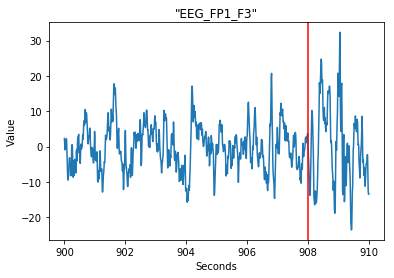

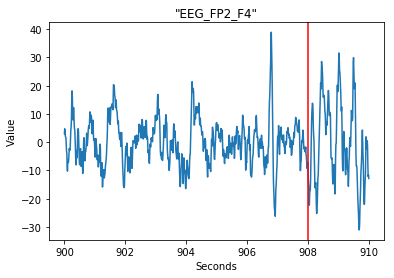

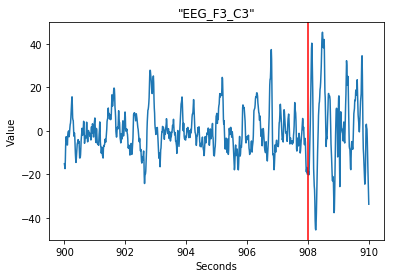

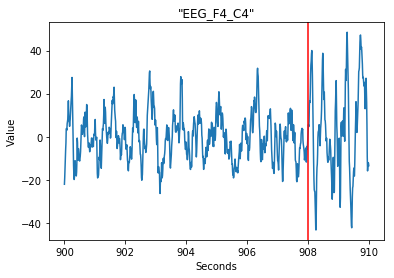

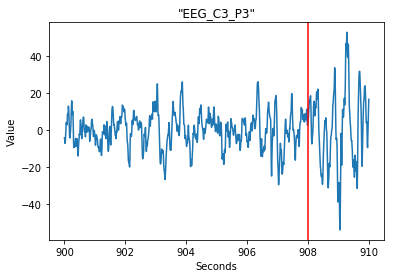

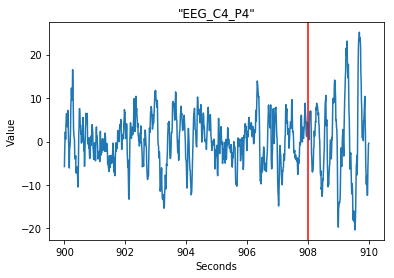

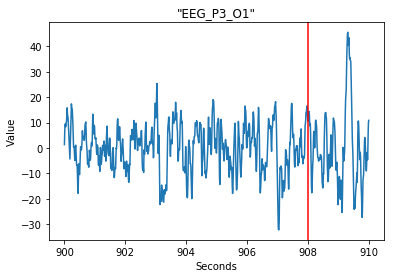

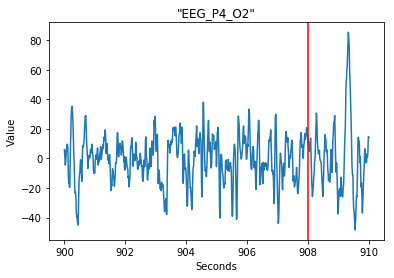

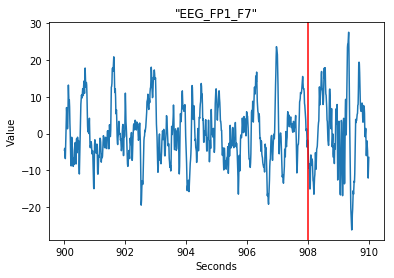

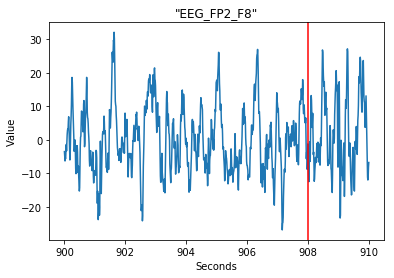

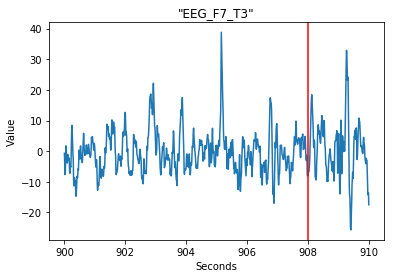

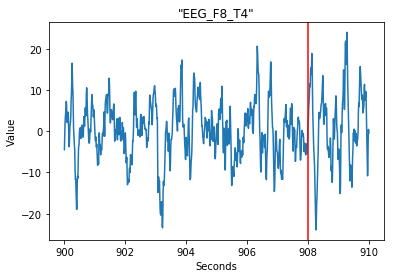

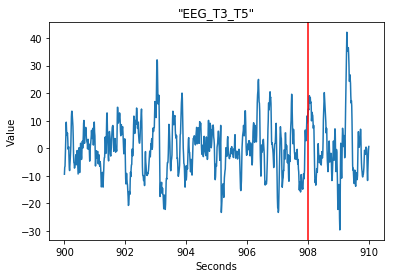

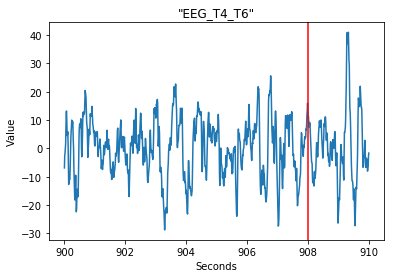

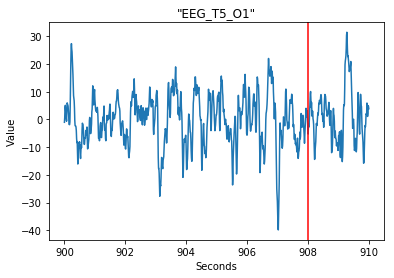

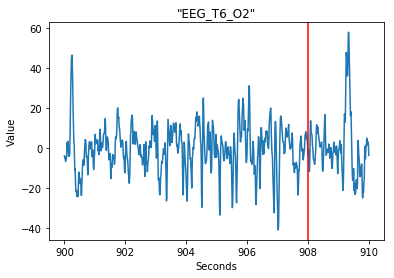

In [29]:
draw_plots(input_data, 
           target, 
           headers, 
           patient=0, 
           start_second=900, 
           end_second=910,
           ratio=FREQUENCY_TO_SAMPLING_RATIO)

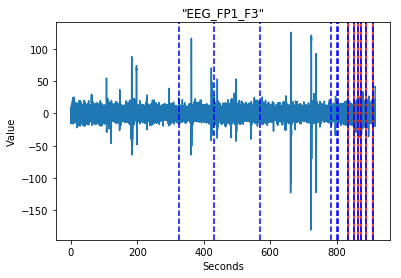

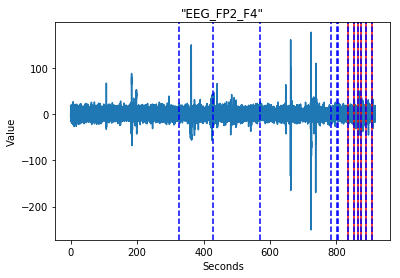

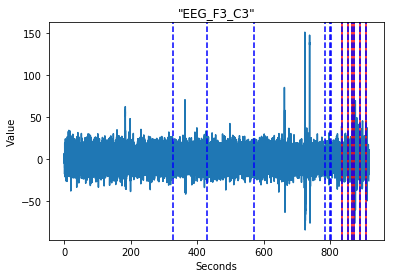

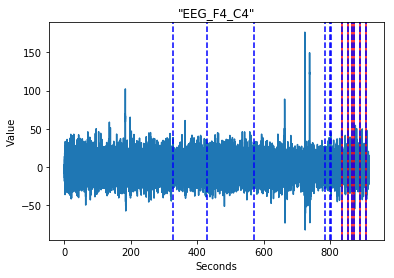

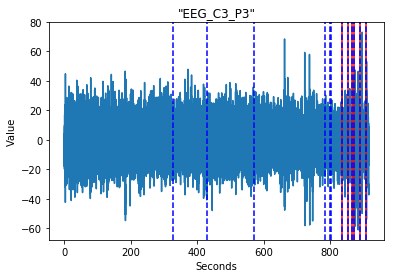

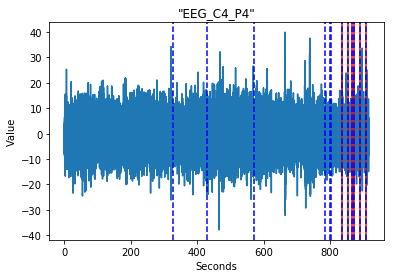

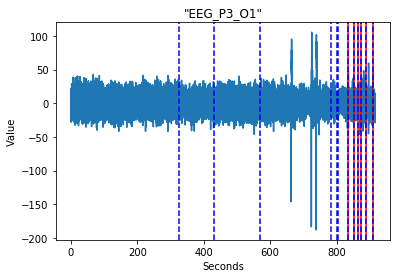

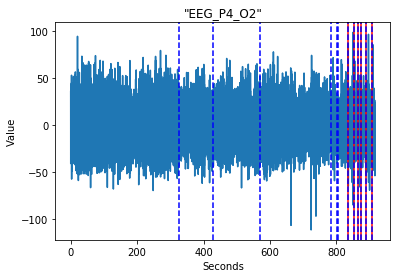

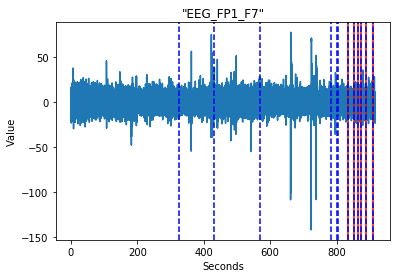

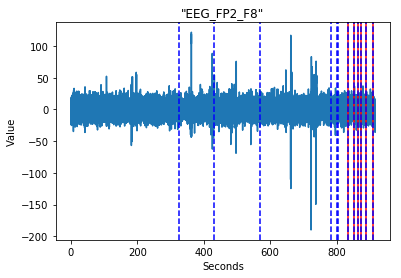

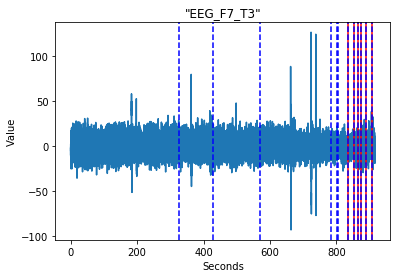

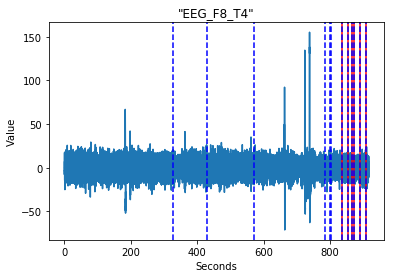

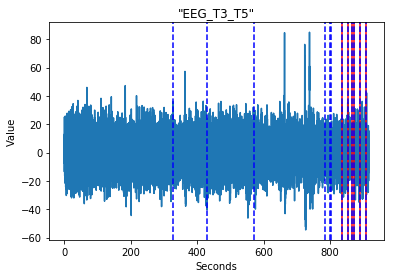

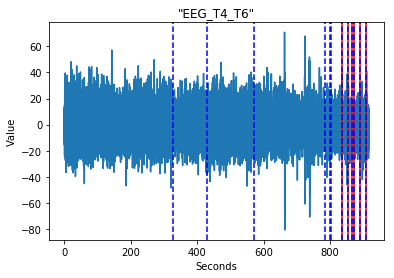

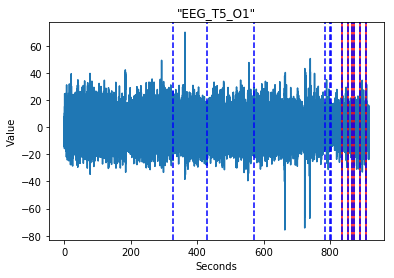

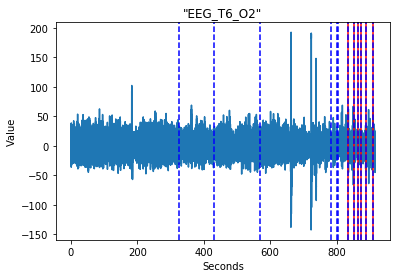

In [30]:
draw_plots_with_chunks(input_data, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)